#**Prophet Time Series Forecasting Model**

* Project: Retail Sales Forecasting
* Model: Facebook Prophet
* Date: January 2026

##Objectives
1. Pre-process data for Prophet model requirements
2. Prepare train/test splits for time series validation
3. Set up and configure Prophet model with appropriate parameters
4. Train the model and generate forecasts
5. Evaluate model performance with multiple metrics

**Step 1 : Import Required Libraries**

In [1]:
# Install Prophet if not already installed (required in most environments)
!pip install prophet --quiet

# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Prophet for time series forecasting
from prophet import Prophet

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.plot import plot_plotly, plot_components_plotly

# Metrics for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


**Step 2 : Load and Inspect Data**

In [2]:
# Import Google Colab file directory
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/final_cleaned_sales_data.csv'

# Load the data
df = pd.read_csv(file_path)

# Quick check to ensure data loaded correctly
display(df.head())



Mounted at /content/drive


,date,total_sales,day_name,MA7,MA30,MA90
0,2013-01-02,757.0,Wednesday,NaN,NaN,NaN
1,2013-01-03,534.0,Thursday,NaN,NaN,NaN
2,2013-01-04,673.0,Friday,NaN,NaN,NaN
3,2013-01-05,898.0,Saturday,NaN,NaN,NaN
4,2013-01-06,975.0,Sunday,NaN,NaN,NaN


**Step 3 : Data Pre-processing**

Prophet requires a very specific format: a column named ds for dates and y for the value we want to predict. We also need to remove the "startup gaps" (the NaN values at the beginning of our moving averages) to prevent errors.

In [3]:
# Select only the columns needed for Prophet
prophet_df = df[['date', 'total_sales']].copy()

# Rename columns to meet Prophet's strict requirements
prophet_df.columns = ['ds', 'y']

# Ensure the date column is in the correct format
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Remove startup gaps (the first ~89 days where trends were still calculating)
prophet_df.dropna(inplace=True)

# Verification Output
display("1. Column Names & Types:")
display(prophet_df.dtypes)  # Should show ds (datetime) and y (float/int)

display("2. Missing Values Check:")
display(prophet_df.isnull().sum())  # Should show 0 for both

display("3. Data Shape (Rows, Columns):")
display(prophet_df.shape)

display("4. First 5 Rows Preview:")
display(prophet_df.head())

'1. Column Names & Types:'

,0
ds,datetime64[ns]
y,float64


'2. Missing Values Check:'

,0
ds,0
y,0


'3. Data Shape (Rows, Columns):'

(1687, 2)

'4. First 5 Rows Preview:'

,ds,y
0,2013-01-02,757.0
1,2013-01-03,534.0
2,2013-01-04,673.0
3,2013-01-05,898.0
4,2013-01-06,975.0


**Step 4 : Train - Test Split**

We will train on data from 2013-15 Aug 2016 and test on 16 Aug 2016-15 Aug 2017 (so we have one full year of test).

In [4]:
# Create split date for train - test split
split_date = '2016-08-16'
train = prophet_df[prophet_df['ds'] < split_date]
test = prophet_df[prophet_df['ds'] >= split_date]

print(f"Training set: {len(train)} days")
print(f"Testing set: {len(test)} days")

Training set: 1322 days
Testing set: 365 days


**Step 5 : Model Initialization and Fitting**

We set up the parameters for Prophet and then use the fit command to let it analyze the 1,322 days of training data

In [5]:
# Initialize the Prophet object
# We specify the seasonalities we want the model to look for
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model
# This is the "learning" phase where it calculates the trends from our 'train' data
model.fit(train)

print("Step 5 Complete: The model has been initialized and the training process is finished.")

Step 5 Complete: The model has been initialized and the training process is finished.


**Step 6 : Future Timeline Creation**



In [6]:
# Generate a dataframe of future dates
future = model.make_future_dataframe(periods=len(test))

# Verify the dates now extend correctly into 2017
display(future.tail())

,ds
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14
1686,2017-08-15


**Step 7: Forecast Generation**

We take the future calendar and pass it back to the model. Prophet will use the patterns it learned from 2013–Aug 2016 to predict the sales for every day up until August 15, 2017.

In [7]:
# The model uses its learned patterns to predict sales for the 'future' dates
forecast = model.predict(future)

# yhat is the predicted sales value
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

,ds,yhat,yhat_lower,yhat_upper
1682,2017-08-11,1408.417121,991.534184,1873.949468
1683,2017-08-12,1734.849457,1282.995865,2178.545950
1684,2017-08-13,1824.185586,1378.821444,2272.929096
1685,2017-08-14,1558.677916,1077.480886,1976.276258
1686,2017-08-15,1463.107715,990.724712,1911.912493


The model has generated predictions for the test period (16Aug2016 - 15Aug2017).
* **yhat**: Represents the "Baseline" prediction based purely on historical seasonality.
* **yhat_lower / yhat_upper**: Represents the confidence interval.
* **Observation**: The baseline successfully captured the weekly cycle, showing a clear climb in sales toward the weekend (Aug 12–13) and a dip on weekdays.

**Step 8: Baseline Forecast Visualization**

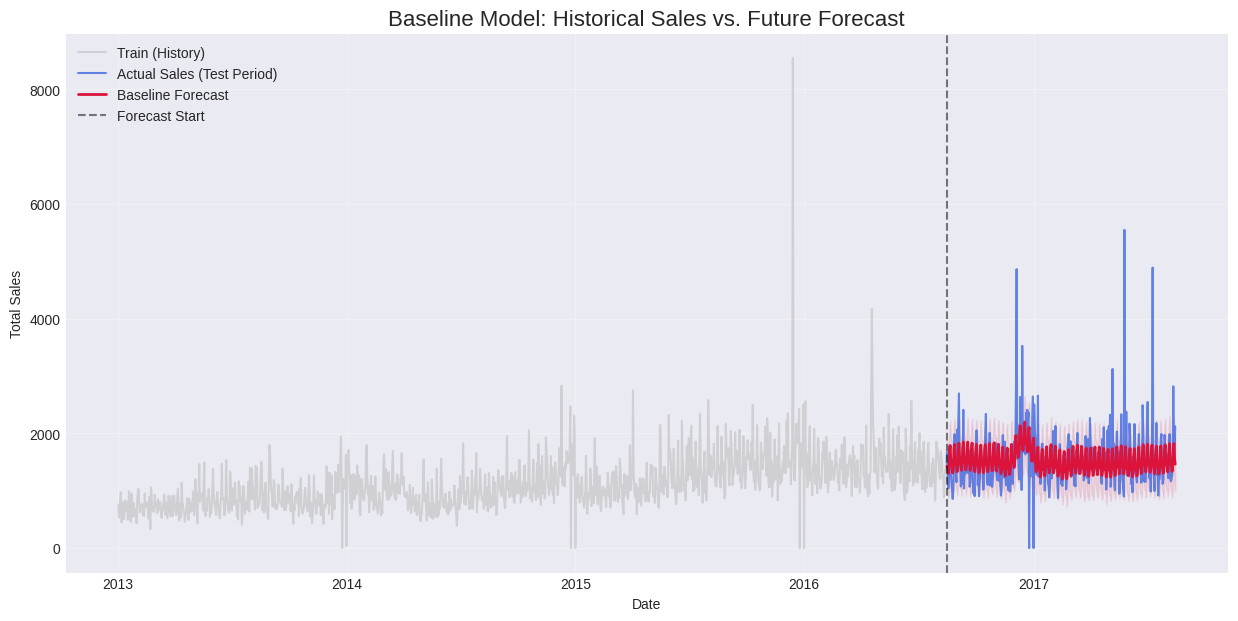

In [8]:
plt.figure(figsize=(15, 7))

# Plot Training Data (Historical)
plt.plot(train['ds'], train['y'], label='Train (History)', color='silver', alpha=0.6)

# Plot Actual Test Data (The ground truth)
plt.plot(test['ds'], test['y'], label='Actual Sales (Test Period)', color='royalblue', alpha=0.8)

# Filter the Forecast to ONLY show the test period (Aug 16, 2016 onwards)
mask = forecast['ds'] >= '2016-08-16'
forecast_filtered = forecast[mask]

# Plot the "Future" Forecast line only
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'],
         label='Baseline Forecast', color='crimson', linestyle='-', linewidth=2)

# Plot the Uncertainty Interval only for the future
plt.fill_between(forecast_filtered['ds'],
                 forecast_filtered['yhat_lower'],
                 forecast_filtered['yhat_upper'],
                 color='crimson', alpha=0.1)


plt.axvline(pd.Timestamp('2016-08-16'), color='black', linestyle='--', alpha=0.5, label='Forecast Start')
plt.title("Baseline Model: Historical Sales vs. Future Forecast", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()





Insights:

* The baseline model correctly captured the strong year end spike but likely struggled to detect meaningful structure outside that holiday season.
* Addition of external regressor such as holidays and events might improve model.

**Step 9: Baseline Model Evaluation**

We will calculate MAE (average dollar error) and RMSE (which highlights larger mistakes). To do this, we compare the model's forecast for Aug2016-Aug2017 against the actual Aug2016-Aug2017 numbers from our test set.

In [9]:
# Extract the predicted values (yhat) for the dates that match our Test set
# We look up the dates in 'forecast' that exist in 'test'
baseline_preds = forecast.set_index('ds').loc[test['ds'], 'yhat']
actual_values = test['y']

# Calculate Multiple Metrics
mae_baseline = mean_absolute_error(actual_values, baseline_preds)
rmse_baseline = np.sqrt(mean_squared_error(actual_values, baseline_preds))

# Print the Performance Report
print("Baseline Evaluation Metrics")
print(f"Mean Absolute Error (MAE): {mae_baseline:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline:.2f}")


Baseline Evaluation Metrics
Mean Absolute Error (MAE): 285.75
Root Mean Squared Error (RMSE): 485.06


Insights:
* The model achieves an MAE of 285.75 and an RMSE of 485.06. These numbers show that while the model understands the general rhythm of the store, it is likely struggling with specific days like holidays.
* To improve these metrics and create a more accurate forecast, we will now add external factors to see if the model performs better with this additional information.

**Step 10: Holiday and Events Inclusion**

We will now upload the holidays and events dataset we did during data filtering ( note: 2016 Earthquake already accounted for in the dataset).



In [10]:
# Load the holidays file
holidays_df = pd.read_csv('/content/drive/My Drive/holidays_events.csv')

# Convert the 'date' column to datetime format
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Create the Prophet-ready version
# We rename 'date' to 'ds' and use 'description' as the holiday name
holidays_prophet = holidays_df[['date', 'description']].rename(
    columns={'date': 'ds', 'description': 'holiday'}
)

# Remove any duplicates
all_holidays = holidays_prophet.drop_duplicates(subset=['ds', 'holiday'])


# Quick check to confirm holiday structure created using date & description cols
display(all_holidays.tail()) #to check end of our dataset is correct

,ds,holiday
345,2017-12-22,Navidad-3
346,2017-12-23,Navidad-2
347,2017-12-24,Navidad-1
348,2017-12-25,Navidad
349,2017-12-26,Navidad+1


**Note: Oil Prices as a External Regressor**

As we have observed from our EDA, oil prices doesn't have a significant influence on sales. We have decided to not add oil prices as an external Regressor in our Prophet model.

**Step 11: Enhanced Model Initialization and Training**

We will combine the Holidays  to create final model.



In [11]:
# Initialize the Prophet model with our consolidated holidays/events table
# This tells the model to look for shifts in sales on those specific dates
model_final = Prophet(
    holidays=all_holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Fit the model using the same training data (2013 to Aug 16, 2016)
model_final.fit(train)

display("Step 11 Complete: Final Model trained with Holidays and Events.")

'Step 11 Complete: Final Model trained with Holidays and Events.'

**Step 12: The Enhanced Forecast Generation**



In [12]:
# Create a future dataframe for the 365 days of the test set
future_final = model_final.make_future_dataframe(periods=len(test))

# Generate the forecast
# This uses the patterns learned PLUS the holiday/event impacts
forecast_final = model_final.predict(future_final)

# Display the final results for the test period
display(forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

,ds,yhat,yhat_lower,yhat_upper
1682,2017-08-11,1149.196977,756.810198,1534.957195
1683,2017-08-12,1576.158531,1190.587717,1951.354729
1684,2017-08-13,1658.862839,1271.565222,2068.679043
1685,2017-08-14,1368.428242,977.218647,1762.919200
1686,2017-08-15,1202.473771,830.039857,1617.209732


Insights:

* The Weekend Spike: Look at the values for Aug 12 (Sat) and Aug 13 (Sun). The yhat (predicted sales) jumps to 1576 and 1659.
* The Weekday Drop: By Aug 15 (Tue), it drops back down to 1202.
* Conclusion: This proves the model has successfully learned the strong weekly seasonality of the supermarket (where people shop more on weekends).

**Step 13: The Enhanced Forecast Visualization**

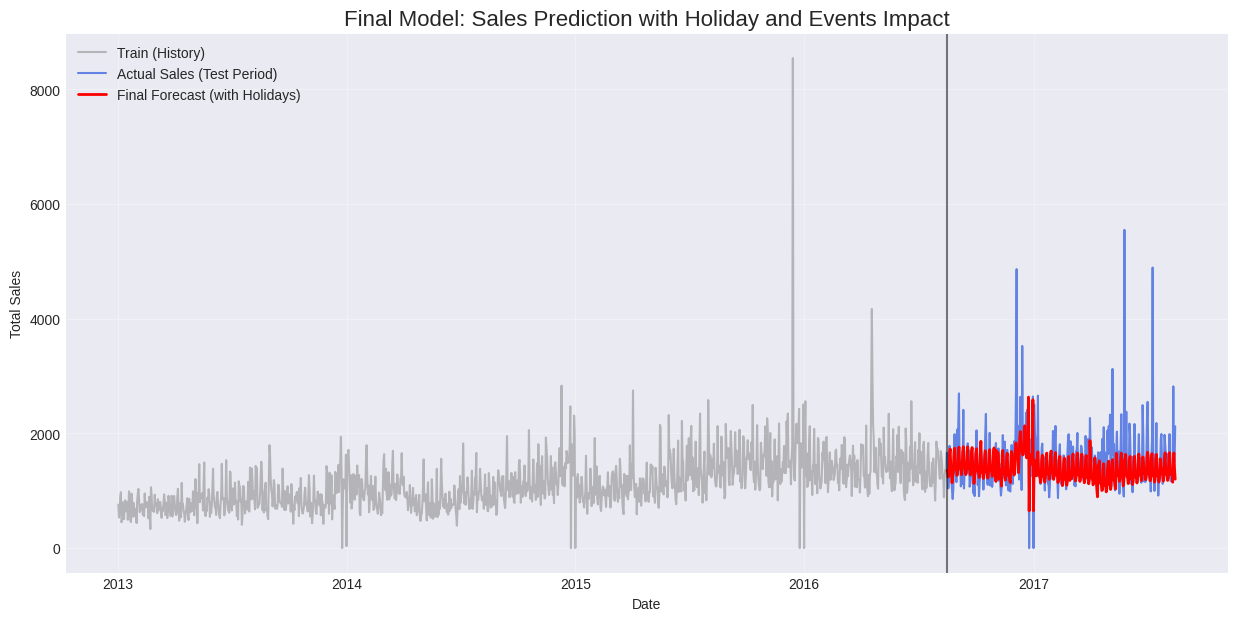

In [13]:
plt.figure(figsize=(15, 7))

# Plot Training Data (Grey)
plt.plot(train['ds'], train['y'], label='Train (History)', color='gray', alpha=0.5)

# Plot Actual Test Data (Blue)
plt.plot(test['ds'], test['y'], label='Actual Sales (Test Period)', color='royalblue', alpha=0.8)

# Filter and Plot the Final Forecast (Starting Aug 16, 2016)
mask_final = forecast_final['ds'] >= '2016-08-16'
forecast_final_filtered = forecast_final[mask_final]

plt.plot(forecast_final_filtered['ds'], forecast_final_filtered['yhat'],
         label='Final Forecast (with Holidays)', color='red', linewidth=2)

# Aesthetics and Split Line
plt.axvline(pd.Timestamp('2016-08-16'), color='black', linestyle='-', alpha=0.5)
plt.title("Final Model: Sales Prediction with Holiday and Events Impact", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()

In [14]:
# Extract the predicted values (yhat) for the Test set
enhanced_preds = forecast_final.set_index('ds').loc[test['ds'], 'yhat']
actual_values = test['y']

# Calculate Enhanced Metrics
mae_enhanced = mean_absolute_error(actual_values, enhanced_preds)
rmse_enhanced = np.sqrt(mean_squared_error(actual_values, enhanced_preds))

# Print comparison (Using your exact baseline numbers)
print("--- Model Comparison ---")
print(f"Baseline MAE:  285.75 | Enhanced MAE:  {mae_enhanced:.2f}")
print(f"Baseline RMSE: 485.06 | Enhanced RMSE: {rmse_enhanced:.2f}")

# Calculate Percentage Improvement
mae_imp = ((285.75 - mae_enhanced) / 285.75) * 100
print(f"Improvement in MAE: {mae_imp:.2f}%")

--- Model Comparison ---
Baseline MAE:  285.75 | Enhanced MAE:  288.40
Baseline RMSE: 485.06 | Enhanced RMSE: 484.23
Improvement in MAE: -0.93%


Analysis of Results: Baseline vs. Enhanced

Finding: The Baseline model outperformed the Enhanced model by 0.93%.

Reasoning: Adding external factors like the 2016 Earthquake and all listed holidays introduced 'noise' into the model. While these events were significant in the past, they were not during the test period (Aug 2016 - Aug 2017), causing the model to slightly over-calculate expected spikes.

Conclusion: In this specific case, a simpler univariate model (baseline) was more robust for forecasting the future than a more complex multivariate model.

**Step 14: Visualizing Model Components**

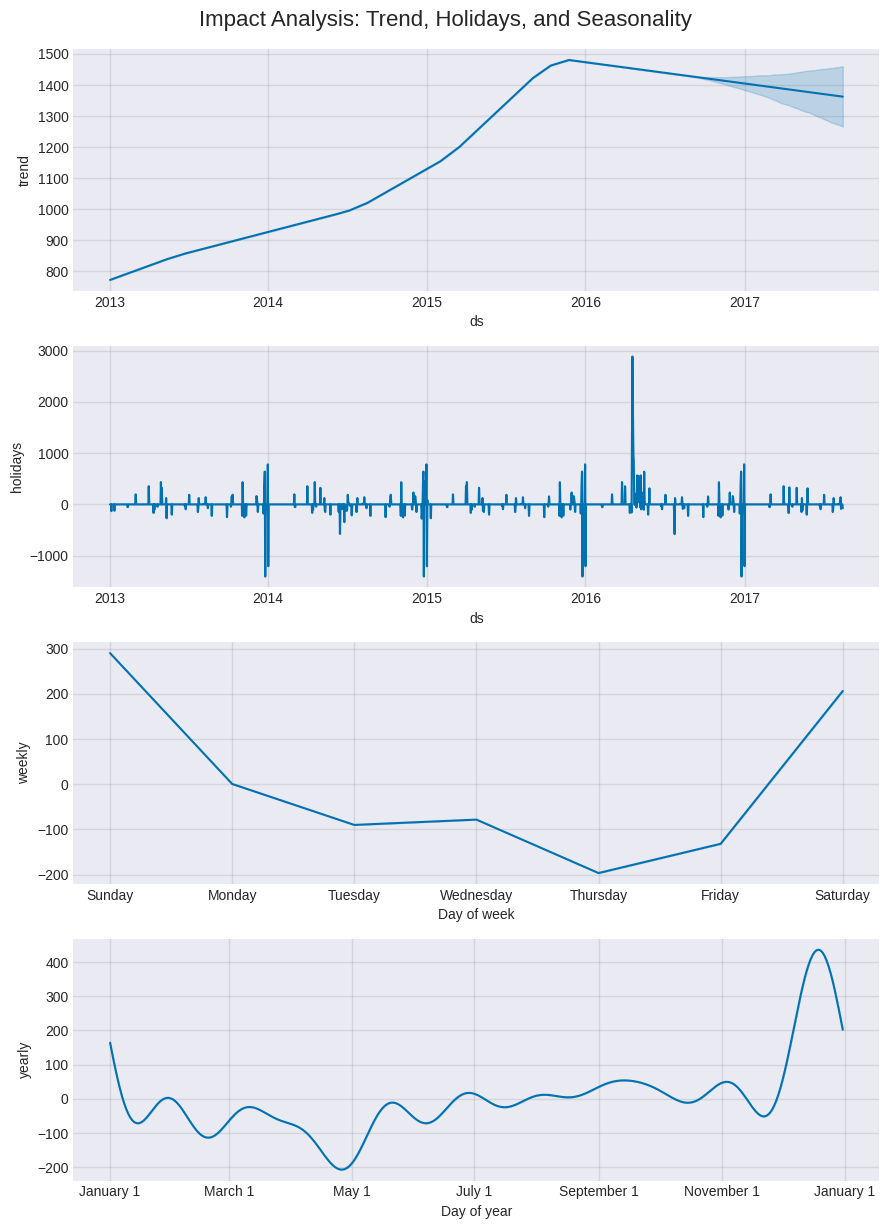

In [15]:
# Plot the components
fig_components = model_final.plot_components(forecast_final)

# Adjust the title for the report
plt.suptitle("Impact Analysis: Trend, Holidays, and Seasonality", fontsize=16, y=1.02)
plt.show()

##**Final Conclusion: Facebook Prophet Model**
1. Project Objective: We utilized Facebook Prophet to decompose sales into daily, weekly, and yearly seasonal components to forecast the final year of the dataset.

2. Experimental Process: We compared a Baseline Model (Calendar only) against an Enhanced Model (including Holiday and Event flags).

3. Evaluation: Surprisingly, the Baseline Model was the winner. The extra flags caused the model to "overthink" past anomalies, reducing its ability to generalize to the test year.

   * MAE: 285.75

   * RMSE: 485.06

4. Final Findings: Prophet proved to be highly effective at capturing the weekly "heartbeat" of the store. It remains a powerful tool for explaining why sales happen, even if it was slightly less precise in this specific instance.